Generate with pre-trained model.

![dump/diffugpt_tokenizer.png](dump/diffugpt_tokenizer.png)

In [33]:
import tiktoken
import torch
from utils import get_annealing_mask
import model
from importlib import reload
reload(model)

# Load model
gpt = model.GPT2("local_config.json")

# Load Tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Prompt
prompt = "Then, the man writes over the snow covering the window of a car, and a woman wearing winter clothes smiles. then"

mask_token = tokenizer.decode([10541])

input_ids = torch.tensor(
    [50256] + tokenizer.encode(prompt)
).unsqueeze(0)

xs = gpt.generate(input_ids, max_new_tokens=10)

for x in xs:
    out = tokenizer.decode(
        x[0].tolist()
    )
    out = out.replace(mask_token, "<mask>")
    print(out)

Modifying HF GPT2Model to accept custom attention mask...
Loading pre-trained DiffuGPT...
<All keys matched successfully>
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True,  True, False, False, False,
         False, False, False, False, False]])
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,  True,
          True, False, False, False, False]])
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False,  True]])
tensor([[False, False, False,

## Test training pipeline

In [26]:
from importlib import reload
import torch
import model
reload(model)

gpt = model.GPT2("local_config.json")

B, C = 2, 10

sentence = torch.randint(0, 100, size = (B, C+1), dtype=int)
input_ids = sentence[:, :-1].clone()
targets = sentence[:, 1:].clone()
input_mask = torch.rand(size=(B, C)) < 0.4

batch = (input_ids, targets, input_mask)
attention_mask = torch.ones(size = (B, C, C)).unsqueeze(1).to(bool)


# gpt.training_step(batch, 0)

Modifying HF GPT2Model to accept custom attention mask...
Initializing new gpt2...


In [28]:
print(input_mask)
attention_mask * input_mask[:, None, None, :].expand(-1, -1, attention_mask.shape[2], -1)

tensor([[False, False, False,  True, False, False,  True, False,  True, False],
        [False, False, False, False, False,  True,  True, False,  True,  True]])


tensor([[[[False, False, False,  True, False, False,  True, False,  True, False],
          [False, False, False,  True, False, False,  True, False,  True, False],
          [False, False, False,  True, False, False,  True, False,  True, False],
          [False, False, False,  True, False, False,  True, False,  True, False],
          [False, False, False,  True, False, False,  True, False,  True, False],
          [False, False, False,  True, False, False,  True, False,  True, False],
          [False, False, False,  True, False, False,  True, False,  True, False],
          [False, False, False,  True, False, False,  True, False,  True, False],
          [False, False, False,  True, False, False,  True, False,  True, False],
          [False, False, False,  True, False, False,  True, False,  True, False]]],


        [[[False, False, False, False, False,  True,  True, False,  True,  True],
          [False, False, False, False, False,  True,  True, False,  True,  True],
          [F

## Insepct the length on examples in FineWeb dataset

In [1]:
from datasets import load_dataset
import tiktoken

enc = tiktoken.get_encoding("gpt2")

SAMPLE_SIZE = 100_000

dataset = load_dataset(
    "HuggingFaceFW/fineweb",    
    "CC-MAIN-2013-20",  
    split = "train",
    streaming=True,
    trust_remote_code=True,
).shuffle(
    buffer_size=10_000,
    seed = 42,
).take(SAMPLE_SIZE)  

def process(example):
    ids = enc.encode_ordinary(example['text'])
    ids.append(enc.eot_token)
    out = {'ids': ids, 'len': len(ids)}
    return out

# Tokenize the dataset
tokenized = dataset.map(
    process,
    remove_columns=['text'],
)

print("Counting valid samples...")
lens = []
for i, sample in enumerate(tokenized):
    if i % 10_000 == 0:
        print(f"Currently at sample: {i}")
    lens.append(sample["len"])

/home/brimax/miniconda3/envs/brimax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Counting valid samples...
Currently at sample: 0
Currently at sample: 1000
Currently at sample: 2000
Currently at sample: 3000
Currently at sample: 4000
Currently at sample: 5000
Currently at sample: 6000
Currently at sample: 7000
Currently at sample: 8000
Currently at sample: 9000
Currently at sample: 10000
Currently at sample: 11000
Currently at sample: 12000
Currently at sample: 13000
Currently at sample: 14000
Currently at sample: 15000
Currently at sample: 16000
Currently at sample: 17000
Currently at sample: 18000
Currently at sample: 19000
Currently at sample: 20000
Currently at sample: 21000
Currently at sample: 22000
Currently at sample: 23000
Currently at sample: 24000
Currently at sample: 25000
Currently at sample: 26000
Currently at sample: 27000
Currently at sample: 28000
Currently at sample: 29000
Currently at sample: 30000
Currently at sample: 31000
Currently at sample: 32000
Currently at sample: 33000
Currently at sample: 34000
Currently at sample: 35000
Currently at sa

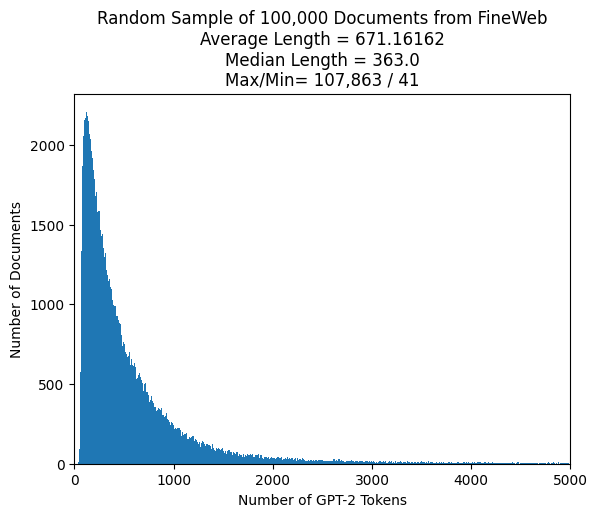

In [35]:
import matplotlib.pyplot as plt
import numpy as np

lens = np.array(lens)
plt.hist(lens, bins = np.arange(0, 5_000, 10))
plt.title(
    f"Random Sample of {SAMPLE_SIZE:,} Documents from FineWeb"
    f"\nAverage Length = {lens.mean()}"
    f"\nMedian Length = {np.median(lens)}"
    f"\nMax/Min= {np.max(lens):,} / {np.min(lens)}"
)
plt.ylabel("Number of Documents")
plt.xlabel("Number of GPT-2 Tokens")
plt.xlim([0, 5_000])
plt.show()

In [162]:
import datamodule 
from importlib import reload
reload(datamodule)

dm = datamodule.MemmapDataModule("local_config.json")

dm.setup()
ids, _, msk = dm.train_dataset[0]
ids

tensor([   50,  5439,   272,  7125,    12,  2816,    12,    32,   911,   789,
        43536,  7123, 10006,    13,   911,   789,  3918, 11662,  2499,   880,
          329,   374,  1040,   278,    11,   262,  4104,   503,  1660,   772,
           82,   523,  4730,   393,   374,  1040,   274,    13,  1629,   362,
           13,    17,  7096,   684,   583, 38573,   262, 43066,  7125,    12,
         2816,    12,    32,   318,   257,  1049,  9014,   329,  3210,  9551,
          515,   393,   406,  5669,   283,  5202,   277, 14272,   316,  6665,
           13,   198,    91, 15667,    25, 15886, 42670,   290, 44171,    91,
          198,    91,    37, 14272,   316,  2142, 27018,    25, 15886,    32,
          263,  1352,    91, 50256, 50257, 50257, 50257, 50257, 50257, 50257])

In [194]:
from importlib import reload
import model
reload(model)
import torch
gpt = model.GPT2("local_config.json")

# gpt.eval()
out = gpt.gpt2.transformer.forward(
    ids[None, :],
    attention_mask=torch.tril(
        torch.ones((1, 1,ids.shape[0], ids.shape[0]))
    )
).last_hidden_state

out1 = gpt.gpt2.lm_head.forward(out)
out2 = gpt.gpt2.forward(
    ids[None, :],
    attention_mask=torch.tril(
        torch.ones((1, 1,ids.shape[0], ids.shape[0]))
    )
).logits

torch.allclose(out1, out2)

Modifying HF GPT2Model to accept custom attention mask...
Initializing new gpt2...


False